<a href="https://colab.research.google.com/github/jklbpl/Conformal/blob/drafts/regression_sign%2Babs_signif_worksshitty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
!pip install nonconformist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [40]:
import matplotlib.pyplot as plt

In [41]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.datasets import load_diabetes
from nonconformist.nc import SignErrorErrFunc, AbsErrorErrFunc
from sklearn.ensemble import RandomForestRegressor
from nonconformist.cp import IcpRegressor
from nonconformist.nc import NcFactory

# Splitting our dataset.

In [42]:
#data_data, data_target = fetch_california_housing(return_X_y= True)
data_data, data_target = load_diabetes(return_X_y= True)
df_features = pd.DataFrame(data_data)
df_target = pd.DataFrame(data_target)
idx_size = df_target.size

np.random.seed(2)

idx = np.random.permutation(len(data_data))

# test = 10%, test(test+calib) = 90% (80%+20%)
test_size = int(idx_size  * 0.1)
train_size = idx_size  - test_size
calib_size = int(train_size * 0.2)
train_size = train_size - calib_size

idx_train, idx_cal, idx_test = idx[:train_size], idx[train_size:train_size + calib_size], idx[train_size + calib_size:]


print('Test size: {}'.format(test_size))
print('Calibration size: {}'.format(calib_size))
print('Train size: {}'.format(train_size))


Test size: 44
Calibration size: 79
Train size: 319


# Let's create predictions, using non-conformist library

In [43]:
significance = 0.05

In [44]:
model = RandomForestRegressor()	# Create the underlying model
nc_abs = NcFactory.create_nc(model,err_func = AbsErrorErrFunc())	# Create a default nonconformity function
icp_abs = IcpRegressor(nc_abs)			# Create an inductive conformal regressor

# Fit the ICP using the proper training set
icp_abs.fit(data_data[idx_train, :], data_target[idx_train])

# Calibrate the ICP using the calibration set
icp_abs.calibrate(data_data[idx_cal, :], data_target[idx_cal])

# Produce predictions for the test set, with confidence 95%
prediction_abs = icp_abs.predict(data_data[idx_test, :], significance=significance)

# Print the first 5 predictions
print(prediction_abs[:5, :])

[[ 41.73 248.13]
 [  8.65 215.05]
 [ 81.13 287.53]
 [-32.73 173.67]
 [100.35 306.75]]


# Now, let's display same predictions (or very very close ones) by using conformal predictor from scratch. 

In [45]:
predictions_cal = model.predict(data_data[idx_cal,:])
predictions_test = model.predict(data_data[idx_test,:])

**To generate calibration dataset we will use functions *sign_error* or *abs_error*.**

In [46]:
def sign_error(prediction_set, y):
  return (prediction_set - y)

def abs_error(prediction_set, y):
  return np.abs(prediction_set - y)

In [47]:
cal_scores_abs = abs_error(predictions_cal, data_target[idx_cal])

In [48]:
def abs_error_inv(cal_score, significance):
  cal_scores_sorted =  np.sort(cal_score)[::-1]
  quantile_significance = np.quantile(cal_scores_sorted, 1-significance) 
  cal_scores_sorted_bool = cal_scores_sorted >= quantile_significance
  for i in range(len(cal_scores_sorted)):
    if cal_scores_sorted_bool[i]:
      number = i

  return cal_scores_sorted[number]

def sign_error_inv(cal_score, significance):
  cal_scores_sorted = np.sort(cal_score)[::-1]
  quantile_significance_up = np.quantile(cal_scores_sorted, significance/2)
  quantile_significance_low = np.quantile(cal_scores_sorted, 1-significance/2)

  cal_scores_sorted_bool_up = cal_scores_sorted <= quantile_significance_up
  for i in range(len(cal_scores_sorted)):
    if cal_scores_sorted_bool_up[i]:
      number_up = i

  cal_scores_sorted_bool_low = cal_scores_sorted <= (quantile_significance_low)
  for j in range(0,len(cal_scores_sorted)):
    if cal_scores_sorted_bool_low[j]:
      number_low = j
      return number_low, number_up


In [49]:
border_abs = abs_error_inv(cal_scores_abs, significance)
intervals_abs = np.zeros((idx_test.size, 2))
intervals_abs[:, 0] = predictions_test - border_abs
intervals_abs[:, 1] = predictions_test + border_abs

print(np.sum(intervals_abs != prediction_abs))

0


In [51]:
cal_scores_sorted = np.sort(cal_scores_sign)[::-1]

quantile_significance_up = np.quantile(cal_scores_sorted, significance/2)
quantile_significance_low = np.quantile(cal_scores_sorted, 1-significance/2)

cal_scores_sorted_bool_up = cal_scores_sorted <= quantile_significance_up
for i in range(len(cal_scores_sorted)):
  if cal_scores_sorted_bool_up[i]:
    number_upp = i

cal_scores_sorted_bool_low = cal_scores_sorted <= (quantile_significance_low)
for i in range(0,len(cal_scores_sorted)):
  if cal_scores_sorted_bool_low[i]:
    number_loww = i
    break

print("num_low: {} \n num_up: {}".format(number_loww,number_upp))
print("cal_low: {} \n cal_up: {}".format(cal_scores_sorted[number_loww],-cal_scores_sorted[number_upp]))

num_low: 2 
 num_up: 78
cal_low: 103.62 
 cal_up: 96.61


In [52]:
model = RandomForestRegressor()	# Create the underlying model
nc_sign = NcFactory.create_nc(model,err_func = SignErrorErrFunc())	# Create a default nonconformity function
icp_sign = IcpRegressor(nc_sign)			# Create an inductive conformal regressor

# Fit the ICP using the proper training set
icp_sign.fit(data_data[idx_train, :], data_target[idx_train])

# Calibrate the ICP using the calibration set
icp_sign.calibrate(data_data[idx_cal, :], data_target[idx_cal])

# Produce predictions for the test set, with confidence 95%
prediction_sign = icp_sign.predict(data_data[idx_test, :], significance=significance)

# Print the first 5 predictions
print(prediction_sign[:5, :])

[[ 44.69 244.92]
 [ 21.7  221.93]
 [ 85.48 285.71]
 [-26.53 173.7 ]
 [ 95.84 296.07]]


In [53]:
cal_scores_sign = sign_error(predictions_cal, data_target[idx_cal])
predictions_cal = model.predict(data_data[idx_cal,:])
predictions_test = model.predict(data_data[idx_test,:])

In [ ]:
intervals_sign = np.zeros((idx_test.size, 2))
cal_scores_sign_sorted = np.sort(cal_scores_sign)[::-1]
border_low, border_up = sign_error_inv(cal_scores_sign, significance)
intervals_sign[:, 0] = predictions_test - (-cal_scores_sign_sorted[border_up])
intervals_sign[:, 1] = predictions_test + cal_scores_sign_sorted[border_low]

print(np.sum(intervals_sign != prediction_sign))
intervals_sign

Text(0.5, 1.0, 'Distribution of calibrated values')

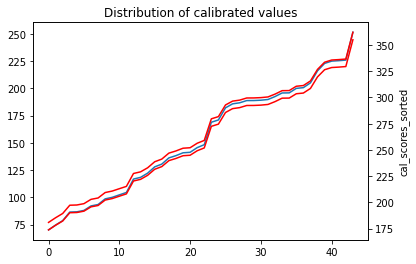

In [56]:
plt.plot(np.sort(predictions_test))
plt.twinx()
plt.plot(np.sort(intervals_sign[:,1]), color='r', linestyle='-')
plt.plot(np.sort(prediction_sign[:,1]), color='r', linestyle='-')
plt.ylabel('cal_scores_sorted')
plt.title('Distribution of calibrated values')

Text(0.5, 1.0, 'Distribution of calibrated values')

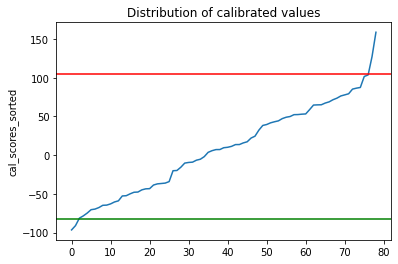

In [57]:
plt.plot(np.sort(cal_scores_sorted))
#plt.grid(True)
plt.axhline(y=quantile_significance_low, color='r', linestyle='-')
plt.axhline(y=quantile_significance_up, color='g', linestyle='-')
plt.ylabel('cal_scores_sorted')
plt.title('Distribution of calibrated values')